In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import glob

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning removal
warnings.simplefilter(action='ignore', category=RuntimeWarning) # FutureWarning removal

In [3]:
dir = './data/'
seasons = ['spring','summer','fall','winter']
site_files = {season: sorted(glob.glob(dir + f'*PCA_ALL_{season}_5dys.csv')) for season in seasons}

season_data = {season: {'all': pd.DataFrame(columns=['PC1', 'PC2']),
                        'swc': pd.DataFrame(columns=['PC1', 'PC2']),
                        'le' : pd.DataFrame(columns=['PC1', 'PC2']),
                        'h'  : pd.DataFrame(columns=['PC1', 'PC2']),
                        'rad': pd.DataFrame(columns=['PC1', 'PC2'])} for season in seasons}
for season in seasons:
    for site in site_files[season][:]:  # Limit to first 2 files for now (adjust as needed)
        f_siteid = site.split("/")[-1].split("_")[0]  # Adjust based on actual file structure
        # print(f_siteid)

        # Read data
        df1 = pd.read_csv(dir + f_siteid + f'_PCApct_ALL_{season}_5dys.csv', na_values=-9999)
        df2 = pd.read_csv(dir + f_siteid + f'_PCApct_NoSWC_{season}_5dys.csv', na_values=-9999)
        df3 = pd.read_csv(dir + f_siteid + f'_PCApct_NoLE_{season}_5dys.csv', na_values=-9999)
        df4 = pd.read_csv(dir + f_siteid + f'_PCApct_NoH_{season}_5dys.csv', na_values=-9999)
        df5 = pd.read_csv(dir + f_siteid + f'_PCApct_NoRAD_{season}_5dys.csv', na_values=-9999)

        # Concatenate DataFrames into their respective categories
        season_data[season]['all'] = pd.concat([season_data[season]['all'], df1], ignore_index=True)
        season_data[season]['swc'] = pd.concat([season_data[season]['swc'], df2], ignore_index=True)
        season_data[season]['le']  = pd.concat([season_data[season]['le'] , df3], ignore_index=True)
        season_data[season]['h']   = pd.concat([season_data[season]['h']  , df4], ignore_index=True)
        season_data[season]['rad'] = pd.concat([season_data[season]['rad'], df5], ignore_index=True)

In [4]:
from scipy import stats

dir        = './data/'
dir_site   = '/glade/derecho/scratch/sungyoon/data/FLUXNET/FULLSET/'
# dir_site   = '/projects/COLA/land/skim/FLUXNET/FULLSET/'

site_files = {season: sorted(glob.glob(dir + f'*PCA_ALL_{season}_5dys.csv')) for season in seasons}
pca_data   = {season: {'pc1' : pd.DataFrame(columns=['SiteID','all_swc','all_le','all_h','all_rad']),
                       'pc2' : pd.DataFrame(columns=['SiteID','all_swc','all_le','all_h','all_rad'])
                       } for season in seasons}

date = 'Unnamed: 0'
for season in seasons:
    for site in site_files[season][:]:  # Limit to first 2 files for now (adjust as needed)
        f_siteid = site.split("/")[-1].split("_")[0]  # Adjust based on actual file structure

        # Read data
        df1 = pd.read_csv(dir + f_siteid + f'_PCA_ALL_{season}_5dys.csv', na_values=-9999)
        df2 = pd.read_csv(dir + f_siteid + f'_PCA_NoSWC_{season}_5dys.csv', na_values=-9999)
        df3 = pd.read_csv(dir + f_siteid + f'_PCA_NoLE_{season}_5dys.csv', na_values=-9999)
        df4 = pd.read_csv(dir + f_siteid + f'_PCA_NoH_{season}_5dys.csv', na_values=-9999)
        df5 = pd.read_csv(dir + f_siteid + f'_PCA_NoRAD_{season}_5dys.csv', na_values=-9999)

        df_site = pd.read_csv((dir_site+f_siteid+'_site.csv'),sep=',')    
        lat     = df_site['Latitude'].item()
        
        if (lat > 0.):
            season_months = {seasons[0]: ['03', '04', '05'],
                             seasons[1]: ['06', '07', '08'],
                             seasons[2]: ['09', '10', '11'],
                             seasons[3]: ['12', '01', '02']}
        else:
            season_months = {seasons[0]: ['09', '10', '11'],
                             seasons[1]: ['12', '01', '02'],
                             seasons[2]: ['03', '04', '05'],
                             seasons[3]: ['06', '07', '08']}
                
        for df in [df1,df2,df3,df4,df5]:
            df[date] = pd.to_datetime(df[date])
        years =df1[date].dt.year.unique()
        # print(years)
        pc1_corrs1_y=[];        pc1_corrs2_y=[];        pc1_corrs3_y=[];        pc1_corrs4_y=[]
        pc2_corrs1_y=[];        pc2_corrs2_y=[];        pc2_corrs3_y=[];        pc2_corrs4_y=[]

        # Removing seasonality in each year and avg of corr.
        for year in sorted(years):
            pc1_corrs1 = [];        pc1_corrs2 = [];        pc1_corrs3 = [];        pc1_corrs4 = []
            pc2_corrs1 = [];        pc2_corrs2 = [];        pc2_corrs3 = [];        pc2_corrs4 = []

            for m in season_months[season]:                
                df_all_m = df1[(df1[date].dt.month == int(m))&(df1[date].dt.year == year)]
                df_swc_m = df2[(df2[date].dt.month == int(m))&(df2[date].dt.year == year)]
                df_le_m  = df3[(df3[date].dt.month == int(m))&(df3[date].dt.year == year)]
                df_h_m   = df4[(df4[date].dt.month == int(m))&(df4[date].dt.year == year)]
                df_rad_m = df5[(df5[date].dt.month == int(m))&(df5[date].dt.year == year)]
                # print(df_all_m)
                if (len(df_all_m) > 1):
                    pc1_p1 = stats.pearsonr(df_all_m["PC1"].values, df_swc_m["PC1"].values)[1]
                    pc1_p2 = stats.pearsonr(df_all_m["PC1"].values, df_le_m ["PC1"].values)[1]
                    pc1_p3 = stats.pearsonr(df_all_m["PC1"].values, df_h_m  ["PC1"].values)[1]
                    pc1_p4 = stats.pearsonr(df_all_m["PC1"].values, df_rad_m["PC1"].values)[1]

                    if ((pc1_p1 < 0.01)&(pc1_p2 < 0.01)&(pc1_p3 < 0.01)&(pc1_p4 < 0.01)):
                        pc1_r1 = stats.pearsonr(df_all_m["PC1"].values, df_swc_m["PC1"].values)[0]
                        pc1_r2 = stats.pearsonr(df_all_m["PC1"].values, df_le_m ["PC1"].values)[0]
                        pc1_r3 = stats.pearsonr(df_all_m["PC1"].values, df_h_m  ["PC1"].values)[0]
                        pc1_r4 = stats.pearsonr(df_all_m["PC1"].values, df_rad_m["PC1"].values)[0]                        
                    else:
                        pc1_r1 = np.NaN; pc1_r2 = np.NaN; pc1_r3 = np.NaN; pc1_r4 = np.NaN
                        
                    pc2_p1 = stats.pearsonr(df_all_m["PC2"].values, df_swc_m["PC2"].values)[1]
                    pc2_p2 = stats.pearsonr(df_all_m["PC2"].values, df_le_m ["PC2"].values)[1]
                    pc2_p3 = stats.pearsonr(df_all_m["PC2"].values, df_h_m  ["PC2"].values)[1]
                    pc2_p4 = stats.pearsonr(df_all_m["PC2"].values, df_rad_m["PC2"].values)[1]

                    if ((pc2_p1 < 0.01)&(pc2_p2 < 0.01)&(pc2_p3 < 0.01)&(pc2_p4 < 0.01)):
                        pc2_r1 = stats.pearsonr(df_all_m["PC2"].values, df_swc_m["PC2"].values)[0]
                        pc2_r2 = stats.pearsonr(df_all_m["PC2"].values, df_le_m ["PC2"].values)[0]
                        pc2_r3 = stats.pearsonr(df_all_m["PC2"].values, df_h_m  ["PC2"].values)[0]
                        pc2_r4 = stats.pearsonr(df_all_m["PC2"].values, df_rad_m["PC2"].values)[0]

                    else:
                        pc2_r1 = np.NaN; pc2_r2 = np.NaN; pc2_r3 = np.NaN; pc2_r4 = np.NaN
                
                else:
                    pc1_r1 = np.NaN; pc1_r2 = np.NaN; pc1_r3 = np.NaN; pc1_r4 = np.NaN
                    pc2_r1 = np.NaN; pc2_r2 = np.NaN; pc2_r3 = np.NaN; pc2_r4 = np.NaN


                pc1_corrs1.append(pc1_r1)
                pc1_corrs2.append(pc1_r2)
                pc1_corrs3.append(pc1_r3)
                pc1_corrs4.append(pc1_r4)
                
                pc2_corrs1.append(pc2_r1)
                pc2_corrs2.append(pc2_r2)
                pc2_corrs3.append(pc2_r3)
                pc2_corrs4.append(pc2_r4)
                # print(m)
                
            # R2 for each season        
            pc1_corrs1_m = np.nanmean(pc1_corrs1)**2
            pc1_corrs2_m = np.nanmean(pc1_corrs2)**2
            pc1_corrs3_m = np.nanmean(pc1_corrs3)**2
            pc1_corrs4_m = np.nanmean(pc1_corrs4)**2
            
            pc2_corrs1_m = np.nanmean(pc2_corrs1)**2
            pc2_corrs2_m = np.nanmean(pc2_corrs2)**2
            pc2_corrs3_m = np.nanmean(pc2_corrs3)**2
            pc2_corrs4_m = np.nanmean(pc2_corrs4)**2
            # print(pc1_corrs1)

            pc1_corrs1_y.append(pc1_corrs1_m)
            pc1_corrs2_y.append(pc1_corrs2_m)
            pc1_corrs3_y.append(pc1_corrs3_m)
            pc1_corrs4_y.append(pc1_corrs4_m)
            
            pc2_corrs1_y.append(pc2_corrs1_m)
            pc2_corrs2_y.append(pc2_corrs2_m)
            pc2_corrs3_y.append(pc2_corrs3_m)
            pc2_corrs4_y.append(pc2_corrs4_m)
            
        # print(pc1_corrs1_y)
        avg_pc1_corrs1 = np.nanmean(pc1_corrs1_y)
        avg_pc1_corrs2 = np.nanmean(pc1_corrs2_y)
        avg_pc1_corrs3 = np.nanmean(pc1_corrs3_y)
        avg_pc1_corrs4 = np.nanmean(pc1_corrs4_y)
        
        avg_pc2_corrs1 = np.nanmean(pc2_corrs1_y)
        avg_pc2_corrs2 = np.nanmean(pc2_corrs2_y)
        avg_pc2_corrs3 = np.nanmean(pc2_corrs3_y)
        avg_pc2_corrs4 = np.nanmean(pc2_corrs4_y)
                
        corr_df1 = pd.DataFrame({'SiteID' : [f_siteid],
                                 'all_swc': [avg_pc1_corrs1],
                                 'all_le' : [avg_pc1_corrs2],
                                 'all_h'  : [avg_pc1_corrs3],
                                 'all_rad': [avg_pc1_corrs4]})
        corr_df2 = pd.DataFrame({'SiteID': [f_siteid],
                                 'all_swc': [avg_pc2_corrs1],
                                 'all_le' : [avg_pc2_corrs2],
                                 'all_h'  : [avg_pc2_corrs3],
                                 'all_rad': [avg_pc2_corrs4]})
        
        pca_data[season]['pc1'] = pd.concat([pca_data[season]['pc1'], corr_df1], ignore_index=True)
        pca_data[season]['pc2'] = pd.concat([pca_data[season]['pc2'], corr_df2], ignore_index=True)

print('done')

done


250
257
256
237


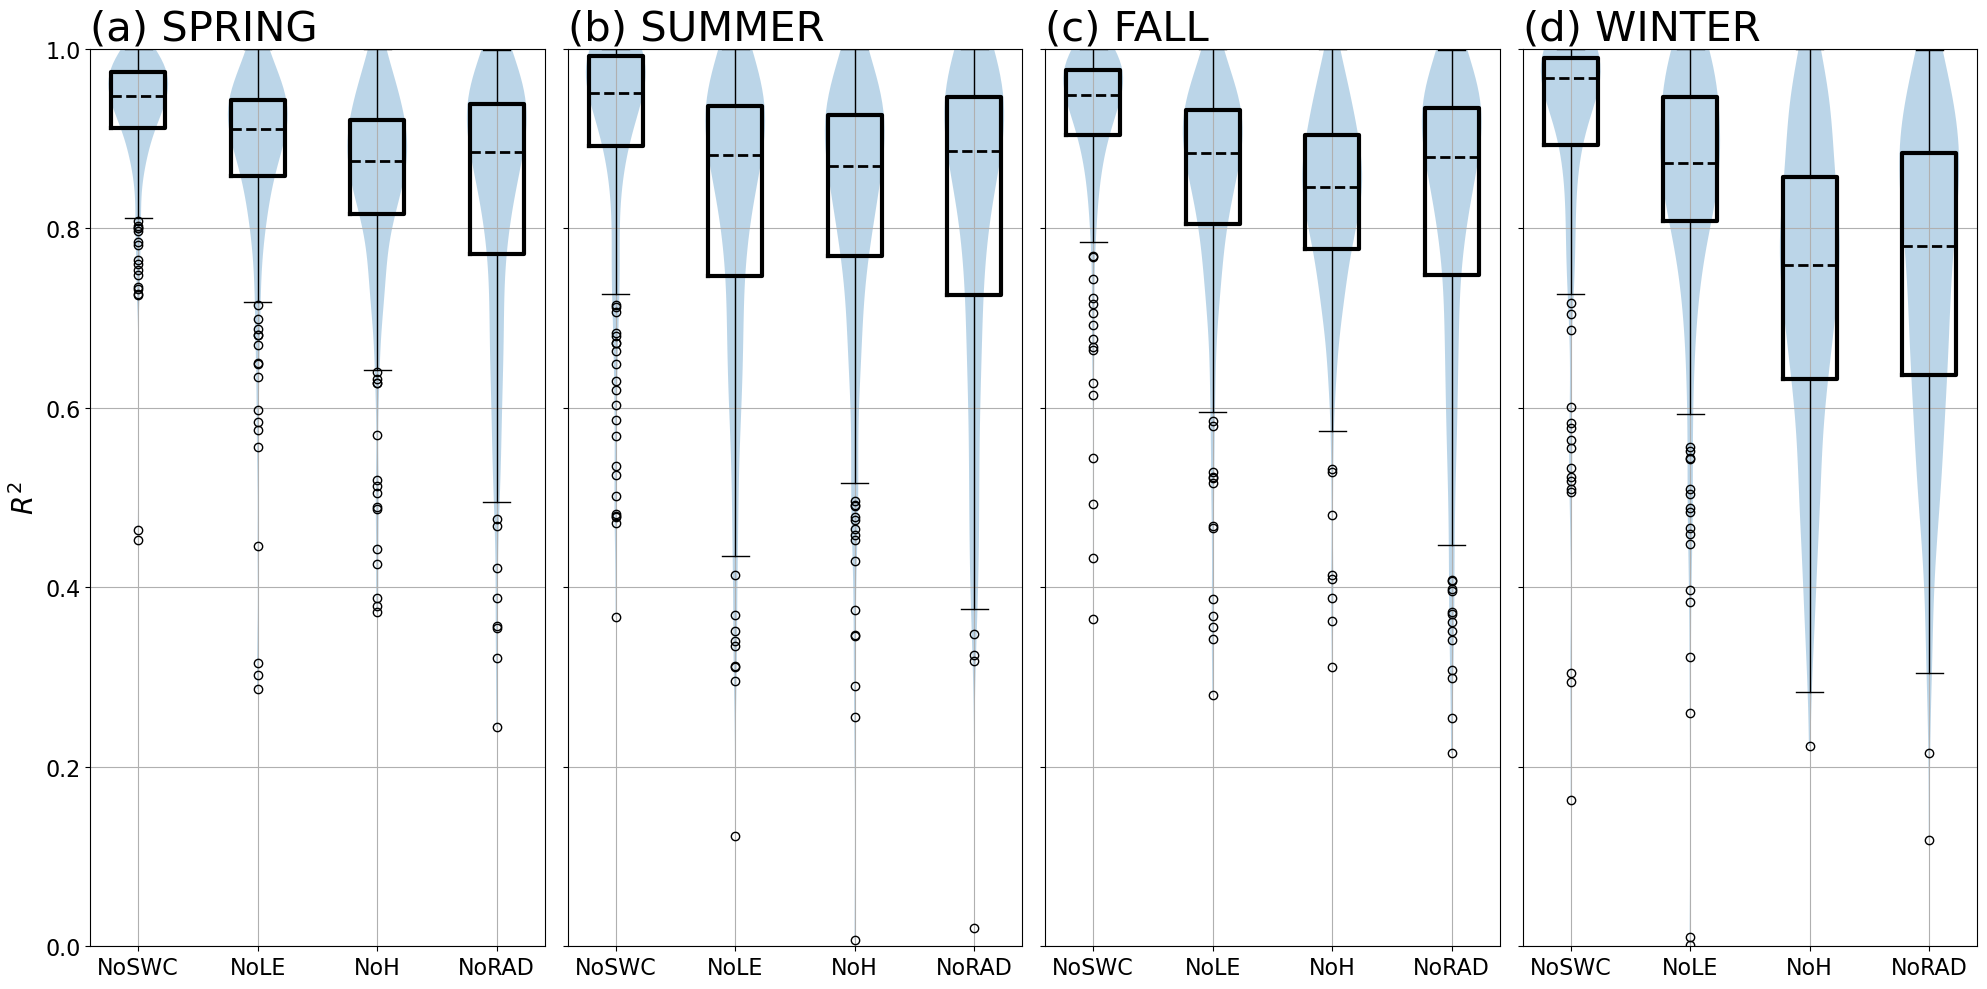

In [5]:
r2_mom = pca_data[seasons[0]]['pc1'].drop(columns=['SiteID']).dropna()
r2_jja = pca_data[seasons[1]]['pc1'].drop(columns=['SiteID']).dropna()
r2_son = pca_data[seasons[2]]['pc1'].drop(columns=['SiteID']).dropna()
r2_djf = pca_data[seasons[3]]['pc1'].drop(columns=['SiteID']).dropna()
print(len(r2_mom))
print(len(r2_jja))
print(len(r2_son))
print(len(r2_djf))
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 10))
axs[0].violinplot(r2_mom, showextrema=False)
axs[1].violinplot(r2_jja, showextrema=False)
axs[2].violinplot(r2_son, showextrema=False)
axs[3].violinplot(r2_djf, showextrema=False)

medianprops = dict(linestyle="--", linewidth=2.0, color="black")
boxprops = dict(linestyle="-", linewidth=3)

axs[0].boxplot(r2_mom, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[1].boxplot(r2_jja, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[2].boxplot(r2_son, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[3].boxplot(r2_djf, medianprops=medianprops, boxprops=boxprops, whis=1.7)

ttl = ["(a) SPRING", "(b) SUMMER", "(c) FALL", "(d) WINTER"]

for i in range(0, 4):
    axs[i].yaxis.grid(True)
    axs[i].xaxis.grid(True)
    axs[i].set_xticks([1, 2, 3, 4])
    axs[i].set_xlim(0.6, 4.4)
    axs[i].set_xticklabels(["NoSWC", "NoLE", "NoH", "NoRAD"])
    axs[i].set_ylim(0, 1)
    axs[i].tick_params(axis="both", which="major", labelsize=16)
    axs[i].set_title(ttl[i], fontsize=30, loc="left")

axs[0].set_ylabel("$R^2$", fontsize=20)

plt.tight_layout()

Figure 2. Distributions of R2 values (y-axis) across stations about surface terms (x-axis) in PC1 from (a) spring, (b) summer, (c) fall, and (d) winter. NoSWC, NoLE, NoH, and NoRAD indicate each surface variable calculated as in Figure 1, respectively. Departures from R2=1 indicate the degree of importance of the missing variable for PC1. Dash lines, boxes, circles, and shading (violin plots) are median values, quartiles, outliers, and probability density functions. The outliers are beyond 3 standard deviations (whiskers). Lighter and darker gray shades on the background indicate the range of R2 thresholds in Figure 3.

250
249
254
236


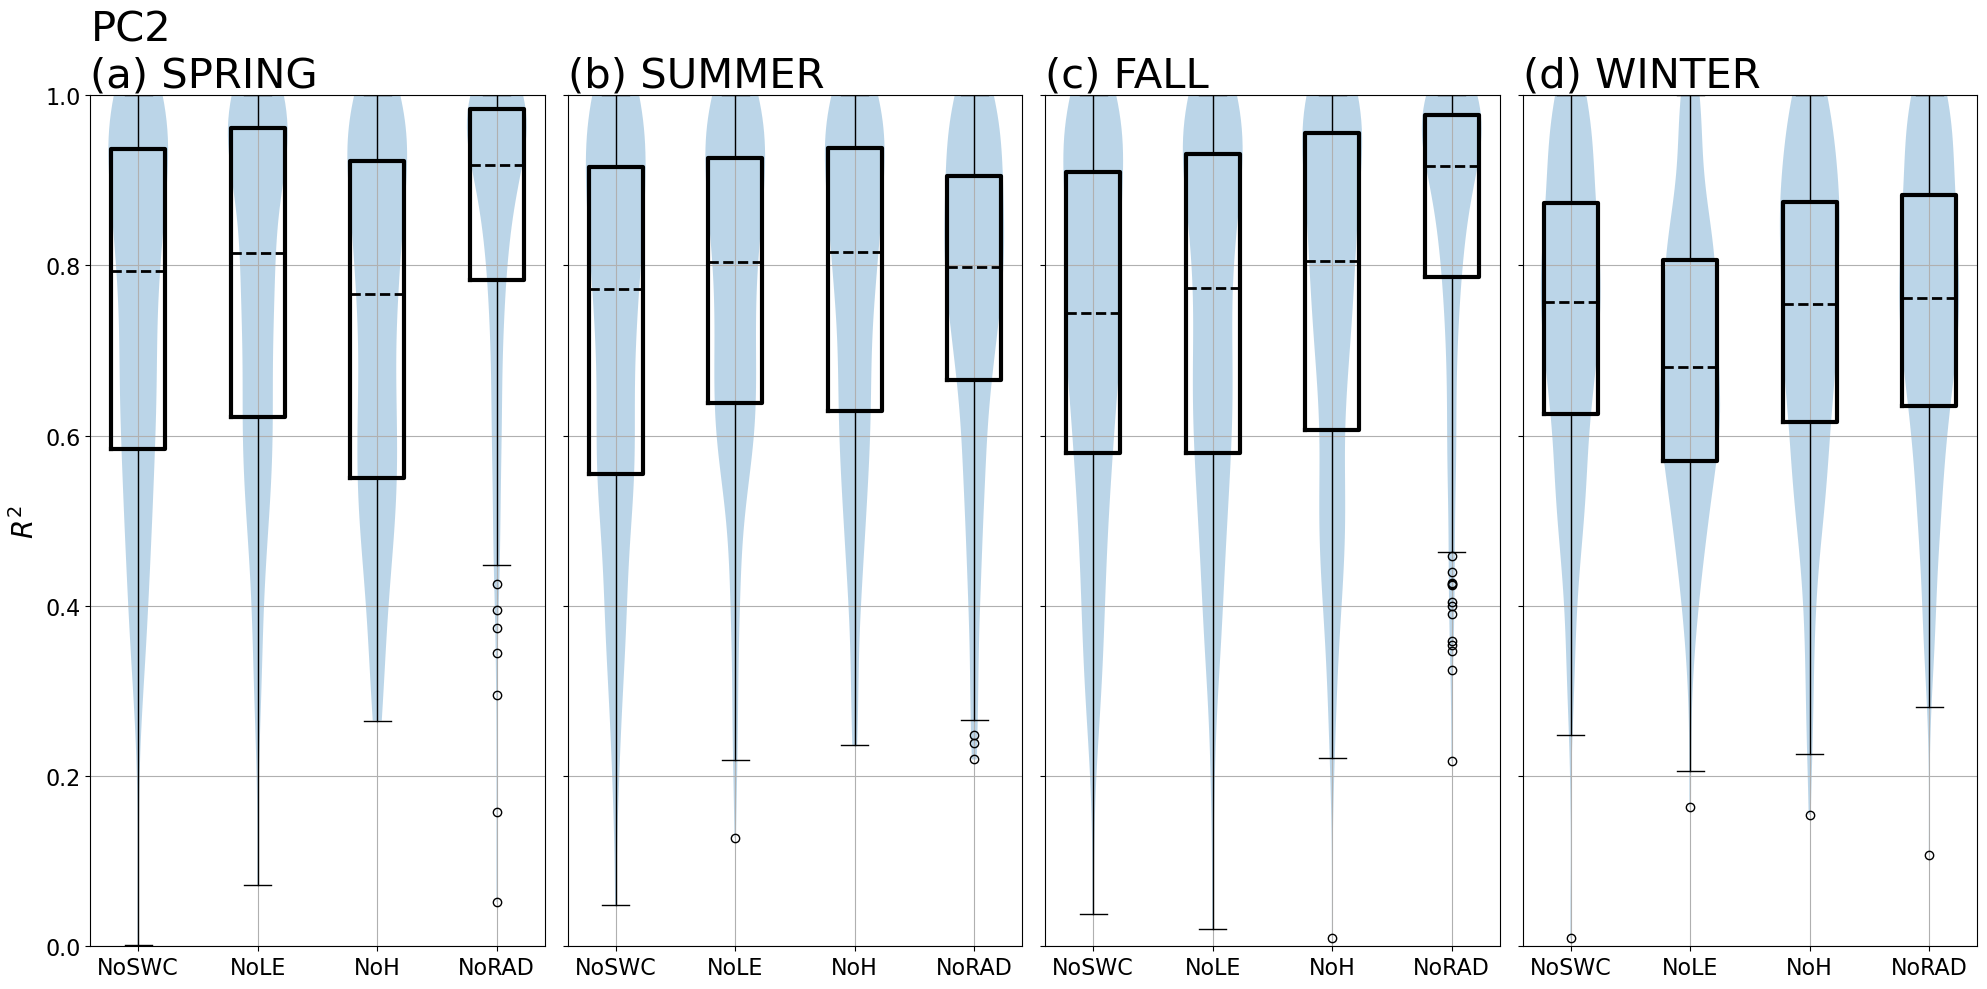

In [6]:
r2_mom2 = pca_data[seasons[0]]['pc2'].drop(columns=['SiteID']).dropna()
r2_jja2 = pca_data[seasons[1]]['pc2'].drop(columns=['SiteID']).dropna()
r2_son2 = pca_data[seasons[2]]['pc2'].drop(columns=['SiteID']).dropna()
r2_djf2 = pca_data[seasons[3]]['pc2'].drop(columns=['SiteID']).dropna()
print(len(r2_mom2))
print(len(r2_jja2))
print(len(r2_son2))
print(len(r2_djf2))
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 10))
axs[0].violinplot(r2_mom2, showextrema=False)
axs[1].violinplot(r2_jja2, showextrema=False)
axs[2].violinplot(r2_son2, showextrema=False)
axs[3].violinplot(r2_djf2, showextrema=False)

medianprops = dict(linestyle="--", linewidth=2.0, color="black")
boxprops = dict(linestyle="-", linewidth=3)

axs[0].boxplot(r2_mom2, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[1].boxplot(r2_jja2, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[2].boxplot(r2_son2, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[3].boxplot(r2_djf2, medianprops=medianprops, boxprops=boxprops, whis=1.7)

ttl = ["PC2\n(a) SPRING", "(b) SUMMER", "(c) FALL", "(d) WINTER"]

for i in range(0, 4):
    axs[i].yaxis.grid(True)
    axs[i].xaxis.grid(True)
    axs[i].set_xticks([1, 2, 3, 4])
    axs[i].set_xlim(0.6, 4.4)
    axs[i].set_xticklabels(["NoSWC", "NoLE", "NoH", "NoRAD"])
    axs[i].set_ylim(0, 1)
    axs[i].tick_params(axis="both", which="major", labelsize=16)
    axs[i].set_title(ttl[i], fontsize=30, loc="left")

axs[0].set_ylabel("$R^2$", fontsize=20)

plt.tight_layout()

(For revision)
Same as Figure 1 except for PC2.